In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from sklearn.feature_selection import f_classif, f_regression, SelectKBest, chi2
from sklearn.ensemble          import IsolationForest

from sklearn.model_selection   import train_test_split
from sklearn.grid_search       import GridSearchCV
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_squared_error, mean_absolute_error, median_absolute_error

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import _pickle           as cPickle

import itertools
import argparse

from commonModel import loadData, FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS, TARGET_COLUMN

modelFileName = "model.pkl"
dataFileName  = "input/NizhnyNovgorod.csv"

Model = None
with open( modelFileName, 'rb') as fid:
        Model = cPickle.load(fid)
allDataFrame = loadData( dataFileName, COLUMN_TYPE='ALL' )

allDataFrame.head(10)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Shape of the data with numerical features: (31831, 11)
RobustScaler  [60493.1008755] [42127.52853091]
Shape of the data with numerical features: (23619, 11)


,type,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors,building_type
0,Вторичка,2850000.0,44.075417,56.283864,43.0,14.0,11.0,1,9,17,
1,Вторичка,8200000.0,43.942485,56.301539,98.5,52.0,14.0,3,3,17,
2,Вторичка,2600000.0,43.923782,56.310448,64.0,42.0,6.0,4,2,5,
3,Вторичка,2750000.0,44.064952,56.291499,50.0,30.0,9.0,2,3,5,
4,Вторичка,2650000.0,43.957127,56.329128,45.0,31.0,6.0,2,2,5,Кирпичный
5,Вторичка,2400000.0,44.023674,56.316345,76.0,44.0,12.0,2,6,9,
6,Вторичка,3700000.0,43.996545,56.317807,45.0,37.0,6.5,2,2,8,Кирпичный
7,Вторичка,3550000.0,44.079100,56.303541,41.8,18.6,11.3,1,9,9,Кирпичный
9,Вторичка,1900000.0,44.001350,56.310740,57.0,27.0,12.0,1,6,12,
11,Вторичка,2800000.0,44.001350,56.310740,91.0,57.0,12.0,3,8,12,


In [2]:
allDataFrame.describe()

,price,longitude,latitude,total_square,living_square,kitchen_square,number_of_rooms,floor_number,number_of_floors
count,2.361900e+04,23619.000000,23619.000000,23619.000000,23619.000000,23619.000000,23619.000000,23619.000000,23619.000000
mean,3.611742e+06,43.945980,56.298797,57.713679,33.133902,9.932467,2.104789,5.706846,10.544011
std,2.189002e+06,0.080570,0.039453,26.371430,16.947655,5.028640,0.949563,4.470376,6.116806
min,5.000000e+05,43.704484,56.116292,12.900000,8.000000,4.000000,1.000000,1.000000,1.000000
25%,2.300000e+06,43.873349,56.270440,41.000000,19.500000,6.800000,1.000000,2.000000,5.000000
50%,3.050000e+06,43.946236,56.303591,52.500000,30.500000,9.000000,2.000000,5.000000,9.000000
75%,4.269750e+06,44.015725,56.326887,68.300000,41.170000,11.700000,3.000000,8.000000,16.000000
max,4.000000e+07,44.209706,56.445076,480.000000,300.000000,95.000000,9.000000,27.000000,28.000000


In [3]:
from commonModel import FLOAT_COLUMNS, INT_COLUMNS, STR_COLUMNS

import warnings
warnings.filterwarnings('ignore')

NUMERICAL_COLUMNS = FLOAT_COLUMNS + INT_COLUMNS
testDataFrame = allDataFrame[NUMERICAL_COLUMNS]

FEATURES = list( testDataFrame.columns ); FEATURES.remove( TARGET_COLUMN )
COLUMNS  = list( testDataFrame.columns ); LABEL = TARGET_COLUMN;

testDataFrame.drop(labels=['floor_number',], axis=1, inplace=True)

index       = testDataFrame.index;
Y_dataFrame = testDataFrame    [[ TARGET_COLUMN ]];       Y_values = Y_dataFrame.values;
X_dataFrame = testDataFrame.drop( TARGET_COLUMN, axis=1); X_values = X_dataFrame.values;
Y_values    = Y_values.ravel()

Y_predict = Model.predict( X_values )

print( "Errors on the test set" )
print( "mean square:     ", mean_squared_error   ( Y_values, Y_predict ) )
print( "mean absolute:   ", mean_absolute_error  ( Y_values, Y_predict ) )
print( "median_absolute: ", median_absolute_error( Y_values, Y_predict ) )

Errors on the test set
mean square:      711936488848.4982
mean absolute:    189760.64724580434
median_absolute:  13027.504099261481


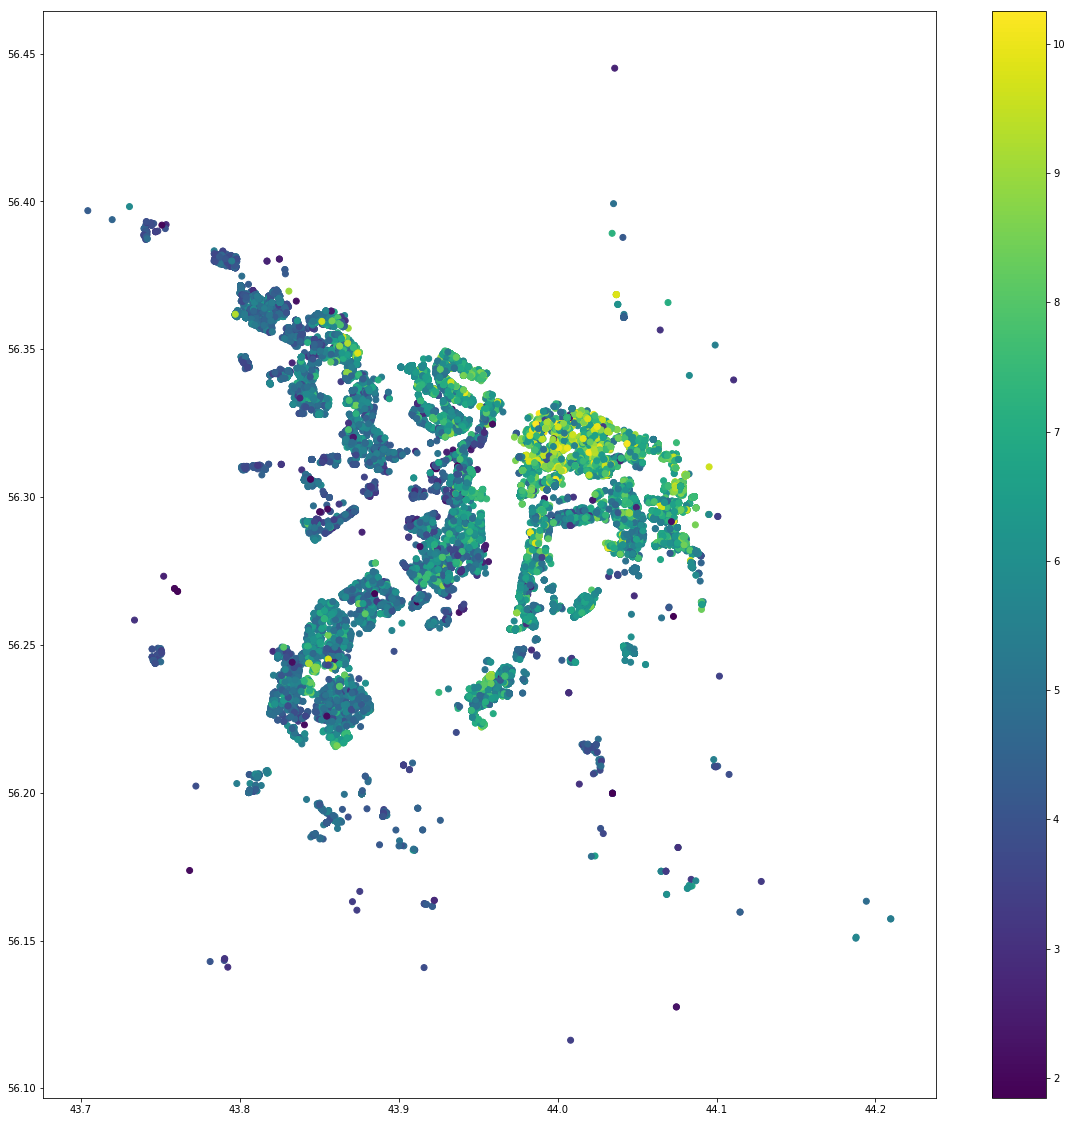

In [4]:
pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

x = X_values[:,0]; y = X_values[:,1];

plt.figure(figsize=(20,20))
plt.scatter (x, y, c=pricePerSquareValues/10000  )
plt.colorbar()


threshold =   2.5, good =      18065, bad =       5554, err = 0.23514966764045894
threshold =   5.0, good =      19900, bad =       3719, err = 0.1574579787459249
threshold =  10.0, good =      21369, bad =       2250, err = 0.09526228883525975
20 20
887 887


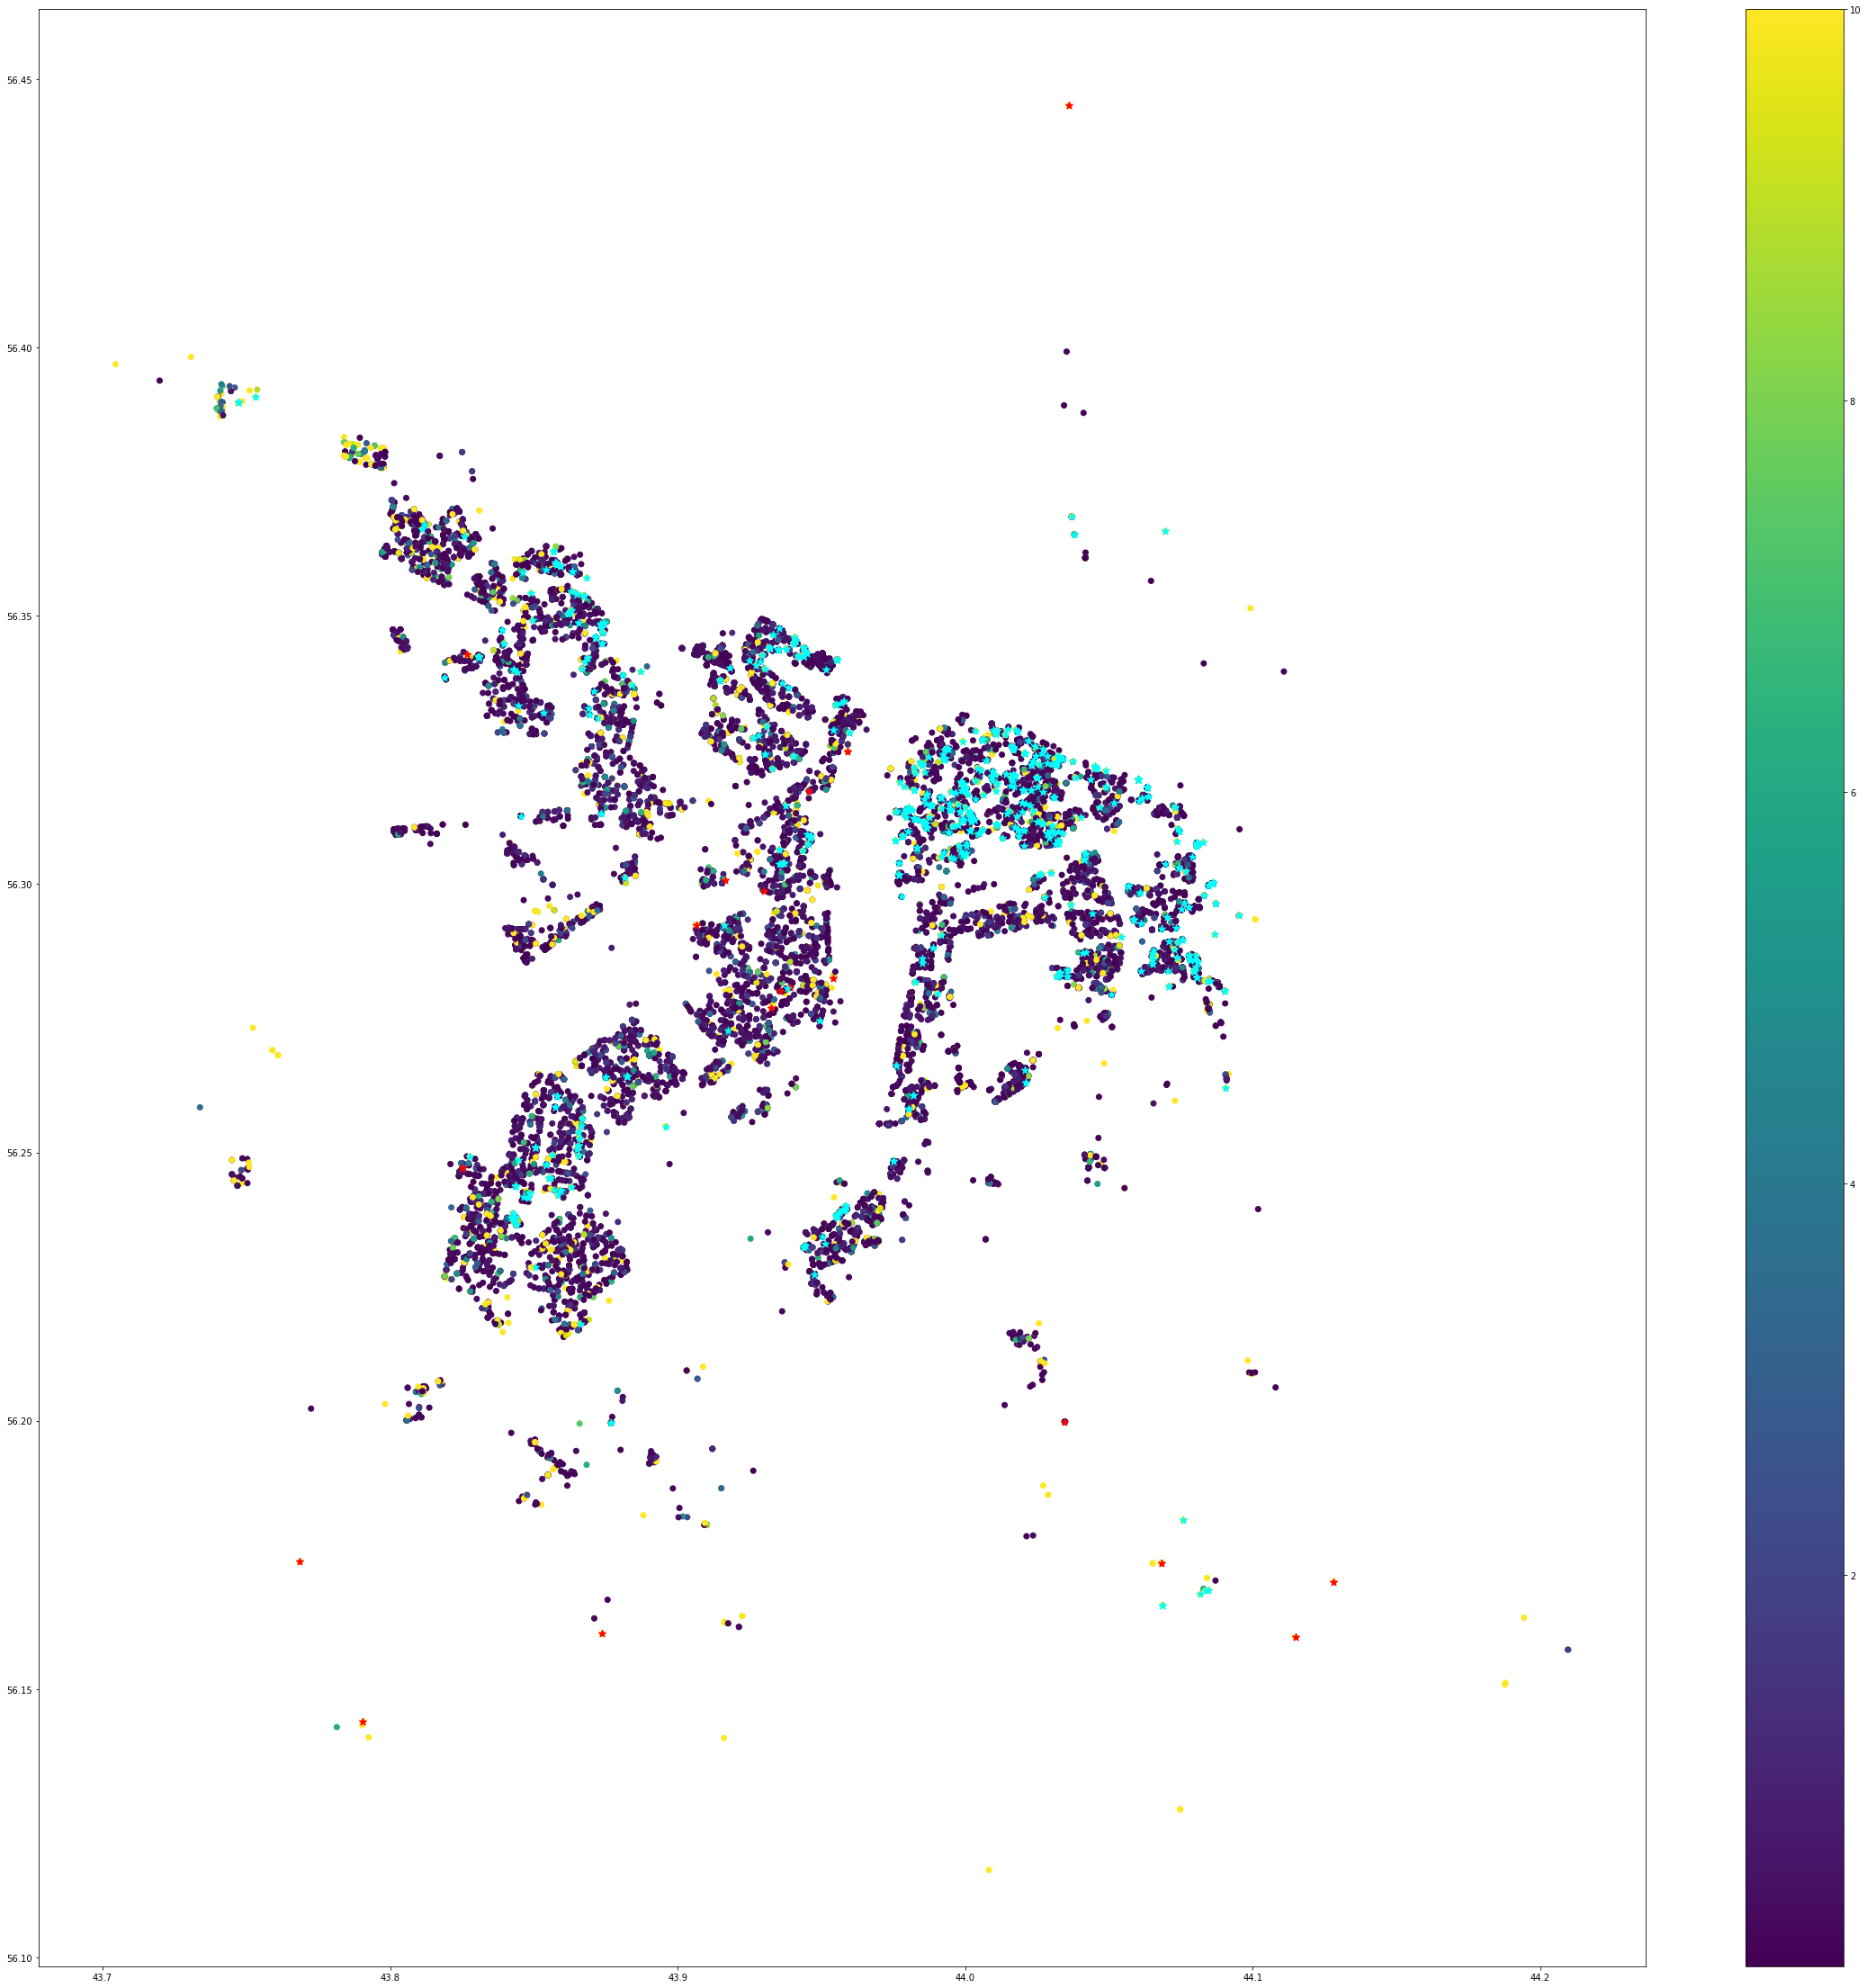

               type       price  longitude   latitude  total_square  \
140        Вторичка   8600000.0  43.943823  56.344062        114.00   
258        Вторичка   5450000.0  43.935199  56.303691         80.30   
339        Вторичка  10300000.0  44.074195  56.303107        121.00   
348        Вторичка   5200000.0  44.035469  56.282800         70.00   
425        Вторичка   5900000.0  43.982208  56.321646         92.10   
520        Вторичка   5490000.0  43.850479  56.250917         79.70   
686        Вторичка   6200000.0  43.848925  56.354243        104.50   
699     Новостройка   5170000.0  43.975848  56.313503        110.00   
704        Вторичка   5399999.0  43.747110  56.389772        188.00   
775        Вторичка  11200000.0  44.001315  56.313134        170.00   
777        Вторичка  25000000.0  44.021806  56.326797        280.00   
780        Вторичка  15100000.0  44.020566  56.324391        226.00   
802        Вторичка   5500000.0  43.992781  56.324995        130.00   
816   

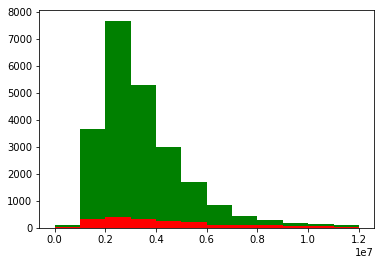

Плохие  примеры [ 20. 322. 413. 330. 262. 229. 108.  98. 101.  78.  60.  35.]
Хорошие примеры [ 105. 3665. 7669. 5285. 2988. 1685.  833.  445.  274.  194.  128.  111.]
Отношение       [ 5.25       11.38198758 18.56900726 16.01515152 11.40458015  7.3580786
  7.71296296  4.54081633  2.71287129  2.48717949  2.13333333  3.17142857]


In [5]:
Y_predict = np.array( Y_predict )
Y_values  = np.array( Y_values  )

Y_relErr = np.abs( Y_predict - Y_values )*100/Y_values
for threshold in [ 2.5, 5.0, 10.0 ]:
    bad_s  = np.sum( ( Y_relErr  > threshold ).astype( np.int ) )
    good_s = np.sum( ( Y_relErr <= threshold ).astype( np.int ) )
    print("threshold = {:5}, good = {:10}, bad = {:10}, err = {:4}".format( threshold, good_s, bad_s, bad_s/(good_s+bad_s)) )
x =  X_values[:,0]; y = X_values[:,1]; c = np.minimum(  Y_relErr, 10 );

plt.figure(figsize=(40,40))
plt.scatter (x, y, c=c  )
plt.colorbar()

mask = ( Y_values < 1e6 ) & ( Y_relErr > 10 )
x_low = X_values[mask,0]; y_low = X_values[mask,1]; c_low = 'red'
print( x_low.size , y_low.size  )
plt.scatter (x_low, y_low, c=c_low, marker="*", s=75  )

mask = ( Y_values > 5e6 ) & ( Y_relErr > 10 )
x_high = X_values[mask,0]; y_high = X_values[mask,1]; c_high = 'aqua'
plt.scatter (x_high, y_high, c=c_high, marker="*", s=75  )
print( x_high.size, y_high.size )
plt.show    ()

print( allDataFrame[ mask ] )

threshold = 10
mask = Y_relErr >  threshold
badTestDataValues = testDataFrame[ mask ].price.values
mask = Y_relErr <= threshold
goodTestDataValues = testDataFrame[ mask ].price.values

bins = [0.,1.,2.,3.,4.,5.,6.,7.,8.,9.,10.,11.,12.]
bins = [i * 1e6 for i in bins]

n = plt.hist([badTestDataValues, goodTestDataValues], bins=bins, histtype='barstacked', color=['red','green'], label = ['bad', 'good'])
plt.show()

#plt.scatter(Y_values,Y_predict)
#plt.plot   (Y_values,Y_values )
#plt.show   ()

print('Плохие  примеры', n[0][0] )
print('Хорошие примеры', n[0][1] )
print('Отношение      ', n[0][1]/n[0][0])

In [6]:
from commonModel import MAX_LONGITUDE, MIN_LONGITUDE, MAX_LATITUDE, MIN_LATITUDE

import warnings
warnings.filterwarnings('ignore')

topK = 10

eps_x = ( MAX_LONGITUDE - MIN_LONGITUDE )*0.001
eps_y = ( MAX_LATITUDE  - MIN_LATITUDE  )*0.001
eps   = min( eps_x, eps_y )

topRelErrIndices = Y_relErr.argsort()[-topK:][::-1]
for i in topRelErrIndices :
    base_row = allDataFrame.iloc[ i ]
    base_x = base_row.longitude 
    base_y = base_row.latitude  
    print("BASE record")
    print( base_row )
    
    for index, cand_row in allDataFrame.iterrows():
        cand_x = cand_row.longitude
        cand_y = cand_row.latitude
        
        distance = np.sqrt( (cand_x-base_x)*(cand_x-base_x) + (cand_y-base_y)*(cand_y-base_y) )
        if distance < eps :
            print("CLOSEST record")
            print( cand_row )
    print("")
    

BASE record
type                Вторичка
price               1.59e+06
longitude            44.0221
latitude              56.299
total_square              65
living_square             34
kitchen_square          25.5
number_of_rooms            1
floor_number               1
number_of_floors           3
building_type               
Name: 92778, dtype: object
CLOSEST record
type                Вторичка
price                3.2e+06
longitude            44.0221
latitude              56.299
total_square            62.2
living_square           42.5
kitchen_square          19.7
number_of_rooms            2
floor_number               2
number_of_floors           3
building_type               
Name: 6971, dtype: object
CLOSEST record
type                Вторичка
price               1.59e+06
longitude            44.0221
latitude              56.299
total_square              65
living_square             34
kitchen_square          25.5
number_of_rooms            1
floor_number               1
number


BASE record
type                Вторичка
price               3.98e+06
longitude            44.0682
latitude             56.1735
total_square             120
living_square             83
kitchen_square            16
number_of_rooms            3
floor_number               5
number_of_floors           5
building_type               
Name: 104862, dtype: object
CLOSEST record
type                Вторичка
price               1.45e+06
longitude            44.0682
latitude             56.1735
total_square              40
living_square             24
kitchen_square             6
number_of_rooms            2
floor_number               1
number_of_floors           3
building_type               
Name: 6824, dtype: object
CLOSEST record
type                Вторичка
price                 850000
longitude            44.0682
latitude             56.1735
total_square              23
living_square             15
kitchen_square             4
number_of_rooms            1
floor_number               1
numb

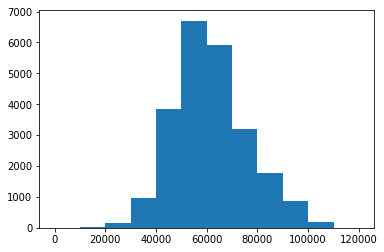

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing.data import QuantileTransformer

import matplotlib.pyplot as plt

bins = [0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000]

pricePerSquare       = allDataFrame['price']/allDataFrame['total_square']
pricePerSquareValues = pricePerSquare.values

plt.hist(  pricePerSquareValues, bins=bins )
plt.show()
